<h1 style='text-align: center;'>Survivor:</h1>
<h2 style='text-align: center;'>Exploring Contestant Trends Through Data</h2>

This projects aims to look at the long-running CBS show Survivor over the years, and determine what demographics of contestants are more likely to win.

We will also be looking to see if there are any trends where certain demographics have lower chances of winning.


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3
# Data pulled in/ saved to csv from 2/19/2025


## Importing Data

In [4]:
contestants = pd.read_csv('contestants.csv')
stats = pd.read_csv('stats.csv')
idols = pd.read_csv('idols.csv')
advantages = pd.read_csv('advantages.csv')
immunities = pd.read_csv('immunities.csv')

## Cleaning Data

After loading the datasets in, it's time to clean the data. 
I want to take the tables for advantages, idols, and individual immunity challenges, and add them to the stats table.

To do this, I create a function that cleans these tables. This function drops unnecessary and duplicate columns, strips column names, replaces and fills values as needed, and changes the dtypes of columns to match the values. It then merges the tables together on the Contestant and Season columns, using outer join for the advantages, idols, and immunities tables so to not lose any data, and then using a left join on the stats table, filtering out any contestants not included elsewhere in the data (ie, from seasons of the Australian version of the show)

In [ ]:
def clean_and_merge(advantages, idols, immunities, stats):
    """
    Cleans tables for advantages, idols and immunities, then merges them to the stats table.
    """
    try:
        # drop columns
        advantages = advantages.drop(columns=['Rank', 'Contestant', 'VV', 'VFB', 'Tie broken?'])
        idols = idols.drop(columns=['Rank', 'Contestant'])
        immunities = immunities.drop(columns=['Rank', 'Contestant'])
        # change column names 
        advantages.columns = advantages.columns.str.strip().str.replace('.1', '')
        idols.columns = idols.columns.str.strip().str.replace('.1', '')
        immunities.columns = immunities.columns.str.strip().str.replace('.1', '')
        # strip and replace values (Season column of S, idols table of special characters (*,†/+,#))
        advantages['Season'] = advantages['Season'].str.replace('S', '')
        advantages['Season'] = advantages['Season'].replace({
            'Game Changers': 34,
            'David vs. Goliath': 37,
            'Winners at War': 40,
            'Cambodia': 31,
            'Island of the Idols': 39,
            'HvHvH': 35,
            'Worlds Apart': 30,
            'Kaoh Rong': 32,
            'Ghost Island': 36,
            'urvivor 42': 42,
            'Edge of Extinction': 38,
            'MvGX': 33   
        })
        advantages['Season'] = advantages['Season'].astype(int) # hopefully the other two go more smoothly

        idols['Season'] = idols['Season'].str.replace('S', '') 
        idols['Contestant'] = idols['Contestant'].str.rstrip('*').str.rstrip('#').str.rstrip('+')
        idols['IH'] = idols['IH'].str.rstrip('*').str.rstrip('#').str.rstrip('+')
        idols['IP'] = idols['IP'].str.rstrip('*').str.rstrip('#').str.rstrip('+')
        idols['VV'] = idols['VV'].str.rstrip('†').str.rstrip('#')
        idols = idols.drop(idols[idols['Season'] == '--'].index)
        idols['IH'] = idols['IH'].astype(int)
        idols['IP'] = idols['IP'].astype(int)
        idols['VV'] = idols['VV'].astype(int)
        idols['Season'] = idols['Season'].astype(int)

        immunities['Season'] = immunities['Season'].str.split(':').str[0]
        immunities['Season'] = immunities['Season'].str.strip('Survivor').str.strip('S')
        immunities['Season'] = immunities['Season'].astype(int)
        
        if 'Notes' in stats.columns:
            print('Tables have already been merged')
            return stats
        else:
            # merge advantages/idols/immunities together (before merging them to stats?)
            merged_idols = pd.merge(idols, advantages, on=['Contestant', 'Season'], how='outer')
            merged_all = pd.merge(merged_idols, immunities, on=['Contestant', 'Season'], how='outer')
            stats = pd.merge(stats, merged_all, on=['Contestant', 'Season'], how='left')
        # reorder columns to be more readable
        stats = stats[['Season', 'Contestant', 'SurvSc', 'SurvAv', 'ChW', 'ChA', 'ChW%',
                                'SO', 'VFB', 'VAP','TotV','TCA','TC%','wTCR','JVF', 'TotJ', 
                                'JV%', 'IF', 'IH', 'IP', 'VV', 'ICW', 'ICA', 'AF', 'AP', 'Notes']]
        
        stats['VAP'] = stats['VAP'].str.rstrip('*')
        stats['TotV'] = stats['TotV'].str.rstrip('*')
        stats['TCA'] = stats['TCA'].str.rstrip('*')
        stats['TC%'] = stats['TC%'].str.rstrip('*')
        stats['wTCR'] = stats['wTCR'].str.rstrip('*')
        # drop rows where SurvSc is null (Season 48 - no values for stats yet)
        stats = stats.dropna(subset='SurvSc')
        # fill null values (notes with NA, everything else with 0)
        stats['Notes'] = stats['Notes'].fillna('NA')
        stats = stats.fillna(0)
        stats = stats.replace('-', '0')
        # to float- survsc, survav, chw, cha, chw%, tc%, wtcr, jv%
        # to int- so, vfb, vap, totv, tca, jvf, totj
        stats.astype({
        'SurvSc': 'float64', 'SurvAv': 'float64', 'ChW': 'float64', 'ChA': 'float64',
        'ChW%': 'float64', 'TC%': 'float64', 'wTCR': 'float64', 'JV%': 'float64',
        'SO': 'int64', 'VFB': 'int64', 'VAP': 'int64', 'TotV': 'int64', 'TCA': 'int64',
        'JVF': 'int64', 'TotJ': 'int64'
        })
    except Exception as e:
        print(f'Error: {e}')

    return stats # will be used to clean idols, advantages, and immunities. 

stats = clean_and_merge(advantages, idols, immunities, stats)

stats.tail()


,Season,Contestant,SurvSc,SurvAv,ChW,ChA,ChW%,SO,VFB,VAP,...,JV%,IF,IH,IP,VV,ICW,ICA,AF,AP,Notes
852,47,Rome Cooney,0.91,2.01,0.39,1.49,0.26,0,3,9,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NA
853,47,Solomon Yi,0.33,1.32,0.89,4.99,0.18,0,1,9,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NA
854,47,Jon Lovett,-0.33,0.17,0.17,0.33,0.5,0,0,5,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NA
855,47,Aysha Welch,-0.27,0.17,0.17,0.73,0.23,1,0,3,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NA
856,47,Tk Foster,-0.51,0.08,0.08,0.53,0.16,0,0,4,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NA


Next, I rename all the columns in the newly merged stats table that were abbreviated to their full meanings, to improve readability. I also write the changes I've made here back to csv, so I can have a cleaned file ready for use in Tableau later.

In [ ]:
def rename_columns(stats) -> pd.DataFrame:
    """
    Rename columns in stats table to be more readable
    """
    stats = stats.rename(columns={
        'SurvSc': 'Survival Score',
        'SurvAv': 'Survival Average',
        'ChW': 'Challenge Wins',
        'ChA': 'Challenge Appearances',
        'ChW%': 'Challenge Win %',
        'SO': 'Sit Outs',
        'VFB': 'Votes For Bootee',
        'VAP': 'Votes Against (Total)',
        'TotV': 'Total Votes Cast',
        'TCA': 'Tribal Council Appearances',
        'TC%': 'Tribal Counicl %',
        'wTCR': 'Tribal Council Ratio (Weighted)',
        'JVF': 'Jury Votes For',
        'TotJ': 'Total Numbers Of Jurors',
        'JV%': 'Jury Votes %',
        'IF': 'Idols Found',
        'IH': 'Idols Held',
        'IP': 'Idols Played',
        'VV': 'Votes Voided',
        'ICW': 'Immunity Challenge Wins',
        'ICA': 'Immunity Challenge Appearances',
        'AF': 'Advantages Found',
        'AP': 'Advantages Played'
    })
    return stats
stats.to_csv('stats.csv', index=False)
stats = rename_columns(stats)
# update/ append or rewrite stats.csv with cleaned data (and ig the other tables (season, contestant) as well) to pull to tableau)
stats.head(3)
# Change 'Alicia Callaway' to 'Alicia Calaway' - alternatively, could use the code for closest match from scraper to ensure the names from contestants are the names in stats. 

,Season,Contestant,Survival Score,Survival Average,Challenge Wins,Challenge Appearances,Challenge Win %,Sit Outs,Votes For Bootee,Votes Against (Total),...,Jury Votes %,Idols Found,Idols Held,Idols Played,Votes Voided,Immunity Challenge Wins,Immunity Challenge Appearances,Advantages Found,Advantages Played,Notes
0,1,Kelly Wiglesworth,1.34,12.26,5.87,16.1,0.36,2,6,0,...,0.43,0.0,0.0,0.0,0.0,4.0,8.0,0.0,0.0,NaN
1,1,Richard Hatch,1.58,7.82,1.87,16.1,0.12,0,9,6,...,0.57,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,1,Rudy Boesch,1.09,3.95,1.62,15.1,0.11,3,10,8,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


Next, I fill the null values in the contestants table, which only consists of the Finish column for the upcoming season 48, which hasn't aired yet and has no data for this column.

In [ ]:
contestants['Finish'] = contestants['Finish'].str.strip('th')
# fill null values
contestants['Finish'] = contestants['Finish'].fillna(0)
# replace Winner, Runner-up, 2nd Runner-up, Co-runner up with 1st or 2nd, respectively
contestants['Finish'] = contestants['Finish'].replace({
    'Winner': '1',
    'Runner-up': 2,
    'Co-runner up': 2,
    '2nd Runner-up': 2,
    '3rd': 3, 
    '1s': 1
})
contestants['Finish'].astype(int)
contestants.head()

,Season,Name,Age,Hometown,Profession,Finish,Ethnicity,Gender,Lgbt,Has Disability,State,Country
0,1,Sonja Christopher,63,"Walnut Creek, CA",Gym Teacher / Retired,16,White,F,True,False,CA,USA
1,1,B.B. Andersen,64,"Mission Hills, KS",Real Estate Developer,15,White,M,False,False,KS,USA
2,1,Stacey Stillman,27,"San Francisco, CA",Attorney,14,White,F,False,False,CA,USA
3,1,Ramona Gray,29,"Edison, NJ",Biochemist,13,African-American,F,False,False,NJ,USA
4,1,Dirk Been,23,"Spring Green, WI",Dairy Farmer,12,White,M,False,False,WI,USA


In [13]:
def extract_state(hometown):
    try:
        if '(' in hometown:
            hometown = hometown.split(' (')[0]
        return hometown.split(', ')[1]
    except:
        print(f'Error- {hometown} unable to be stripped')
    
# Create a new column with the extracted state/province
contestants['State'] = contestants['Hometown'].apply(extract_state)
contestants.head(3)

,Season,Name,Age,Hometown,Profession,Finish,Ethnicity,Gender,Lgbt,Has Disability,State,Country
0,1,Sonja Christopher,63,"Walnut Creek, CA",Gym Teacher / Retired,16,White,F,True,False,CA,USA
1,1,B.B. Andersen,64,"Mission Hills, KS",Real Estate Developer,15,White,M,False,False,KS,USA
2,1,Stacey Stillman,27,"San Francisco, CA",Attorney,14,White,F,False,False,CA,USA


In [14]:
def add_countries(hometown):
    if 'Canada' in hometown:
        return 'Canada'
    else:
        return 'USA'
contestants['Country'] = contestants['Hometown'].apply(add_countries)
contestants.to_csv('contestants.csv', index=False)
contestants.head(3)

,Season,Name,Age,Hometown,Profession,Finish,Ethnicity,Gender,Lgbt,Has Disability,State,Country
0,1,Sonja Christopher,63,"Walnut Creek, CA",Gym Teacher / Retired,16,White,F,True,False,CA,USA
1,1,B.B. Andersen,64,"Mission Hills, KS",Real Estate Developer,15,White,M,False,False,KS,USA
2,1,Stacey Stillman,27,"San Francisco, CA",Attorney,14,White,F,False,False,CA,USA


### Exploratory Data Analysis

In [ ]:
# Mean, median, mode calculations 


In [ ]:
# What I want to explore:
# What are the average placements of various demographics? (Age ranges, gender, ethnicity, possibly profession and hometown)
# Are there any shared demographics of top players? (High Survivor Scores/Averages, Most Idols played, Season winners)
# What do the demographics of winners/runner ups look like? How are jury votes split amongst them and are there any potential biases present?
# What does the geographical distribution of winners look like?


In [ ]:
def sql(query):
    conn = sqlite3.connect('survivor.db')

    df = pd.read_sql_query(query, conn)
    conn.close()
    return df

conn = sqlite3.connect('survivor.db')
# Convert dataframes to SQL table
contestants.to_sql('contestants', conn, if_exists='replace', index=False)
stats.to_sql('stats', conn, if_exists='replace', index=False)


# Close the connection
conn.close()


In [ ]:
# Are there any shared demographics of top players? (High Survivor Scores/Averages, (Most Idols played- not necessarily 'top' players), Season winners)
test_sql = '''
SELECT Ethnicity, COUNT(Ethnicity) as Count
FROM contestants
WHERE Finish = '1st'
GROUP BY Ethnicity
ORDER BY COUNT(Ethnicity);
'''
sql(test_sql)

,Ethnicity,Count
0,African-Canadian,1
1,Asian-Canadian,1
2,Asian-American,3
3,African-American,4
4,Latin American,5
5,White,33


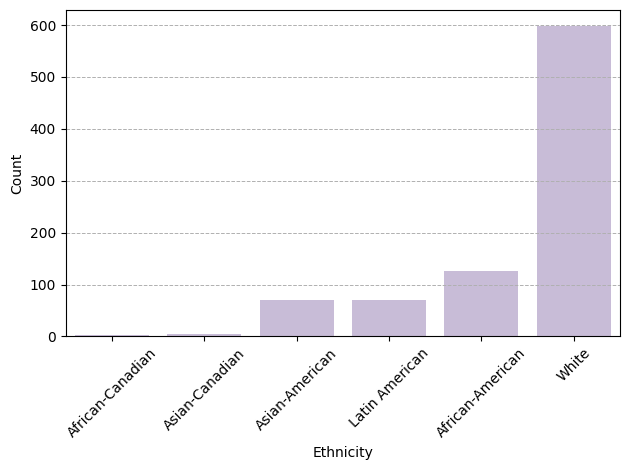

In [36]:
overall_ethnicity = '''
SELECT Ethnicity, COUNT(Ethnicity) as Count
FROM contestants
GROUP BY Ethnicity
ORDER BY Count;
'''
sql(overall_ethnicity)

colors = []

plot = sns.barplot(x='Ethnicity', y='Count', data=sql(overall_ethnicity), color='#c8b8db')
plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show(plot)

In [37]:
# What are the average placements of various demographics? (Age ranges, gender, ethnicity, possibly profession and hometown)
gender_sql = '''
SELECT Gender,COUNT(Gender) as Count
FROM contestants
GROUP BY Gender
ORDER BY Count;
'''
sql(gender_sql)


,Gender,Count
0,N,2
1,F,433
2,M,440


In [ ]:
# Age ranges can probably be defined using CASE, have set Finish to 

In [42]:
disability_placement = '''
SELECT COUNT(s.Contestant) as Count, c.Finish
FROM contestants as c
LEFT JOIN stats as s ON c.Name = s.Contestant
WHERE c.'Has Disability' = True AND Finish <> 'TBD'
GROUP BY c.Finish
ORDER BY Count;
''' 

sql(disability_placement)

,Count,Finish
0,1,5th
1,1,6th
2,1,7th
3,2,15th
4,2,16th
5,2,8th
6,2,9th


In [ ]:
# What does the geographical distribution of winners look like?
location = '''
SELECT State, COUNT(State) as Count
FROM contestants
WHERE Finish = '1st'
GROUP BY State
ORDER BY Count DESC
LIMIT 24;
'''
sql(location)

,State,Count
0,CA,8
1,NY,4
2,NJ,4
3,PA,3
4,UT,2
5,TX,2
6,ON,2
7,NC,2
8,ID,2
9,IA,2


In [14]:
# What do the demographics of winners/runner ups look like? How are jury votes split amongst them and are there any potential biases present?
